In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')

In [54]:
file = pd.ExcelFile('Cleaned.xlsx')
df1 = pd.read_excel(file, 'Transactions')
df2 = pd.read_excel(file, 'CustDemo')
df3 = pd.read_excel(file, 'NewCust')
df4 = pd.read_excel(file, 'CustAddresses')

In [55]:
df = df1.join(df2, how='left', on='customer_id', rsuffix='_cd')
df = df.join(df4, how='left', on='customer_id', rsuffix='_add')

In [56]:
df.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'season', 'Sale_revenue', 'customer_id_cd',
       'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'age', 'agebin', 'customer_id_add', 'address',
       'postcode', 'state', 'country', 'property_valuation', 'metro'],
      dtype='object')

In [57]:
df = df[['customer_id', 'online_order', 'brand', 'product_line', 'product_class', 'product_size', 'list_price', 'standard_cost',
         'season', 'Sale_revenue', 'gender', 'past_3_years_bike_related_purchases', 'job_industry_category', 'wealth_segment', 
         'owns_car', 'tenure', 'age', 'agebin', 'postcode', 'state', 'property_valuation', 'metro']]

In [58]:
#gender, industry, wealth segment, owns car, tenure, state, postcode, prop_val, age/agebin, metro

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19625 entries, 0 to 19999
Data columns (total 22 columns):
customer_id                            19625 non-null int64
online_order                           19273 non-null float64
brand                                  19625 non-null object
product_line                           19625 non-null object
product_class                          19625 non-null object
product_size                           19625 non-null object
list_price                             19625 non-null float64
standard_cost                          19625 non-null float64
season                                 19625 non-null object
Sale_revenue                           19625 non-null float64
gender                                 19121 non-null object
past_3_years_bike_related_purchases    19121 non-null float64
job_industry_category                  15930 non-null object
wealth_segment                         19121 non-null object
owns_car                         

In [60]:
#Need a target - avg customer profit margin in 2017

df['profit_margin'] = (df['list_price'] - df['standard_cost']) / df['list_price']

a = {}
for i in set(df['customer_id']):
    x = df[df['customer_id'] == i]
    y = x['profit_margin'].mean()
    a[i] = y
    
df['avg_cust_pm'] = [a[i] for i in df['customer_id']]
df.describe()

,customer_id,online_order,list_price,standard_cost,Sale_revenue,past_3_years_bike_related_purchases,tenure,age,postcode,property_valuation,metro,profit_margin,avg_cust_pm
count,19625.000000,19273.000000,19625.000000,19625.000000,19625.000000,19121.000000,19121.000000,19121.000000,19622.000000,19622.000000,19622.000000,19625.000000,19625.000000
mean,1739.572994,0.500285,1107.744983,555.821210,551.923772,49.161602,10.703363,42.477642,2990.154928,7.543879,0.767353,0.446117,0.446117
std,1011.957495,0.500013,582.989189,405.977243,493.502909,28.463173,5.676916,12.603182,853.585870,2.820612,0.422530,0.264268,0.114344
min,1.000000,0.000000,12.010000,7.210000,4.800000,0.000000,1.000000,18.000000,2000.000000,1.000000,0.000000,0.072214,0.072214
25%,858.000000,0.000000,575.270000,215.140000,133.780000,25.000000,6.000000,33.000000,2200.000000,6.000000,1.000000,0.249973,0.366861
50%,1737.000000,1.000000,1163.890000,507.580000,445.210000,48.000000,11.000000,43.000000,2767.000000,8.000000,1.000000,0.399998,0.441426
75%,2615.000000,1.000000,1635.300000,795.100000,830.240000,73.000000,15.000000,52.000000,3775.000000,10.000000,1.000000,0.676080,0.518660
max,5034.000000,1.000000,2091.470000,1759.850000,1702.550000,99.000000,22.000000,88.000000,4883.000000,12.000000,1.000000,0.989604,0.989604


In [61]:
df['Target'] = ['Low' if i < 0.37 else 'Below_Avg' if i < 0.44 else 'Above_Avg' if i < 0.52 else 'High' for i in df['avg_cust_pm']]
#Check for class balance
df.Target.value_counts()

Low          5089
Above_Avg    5082
High         4814
Below_Avg    4640
Name: Target, dtype: int64

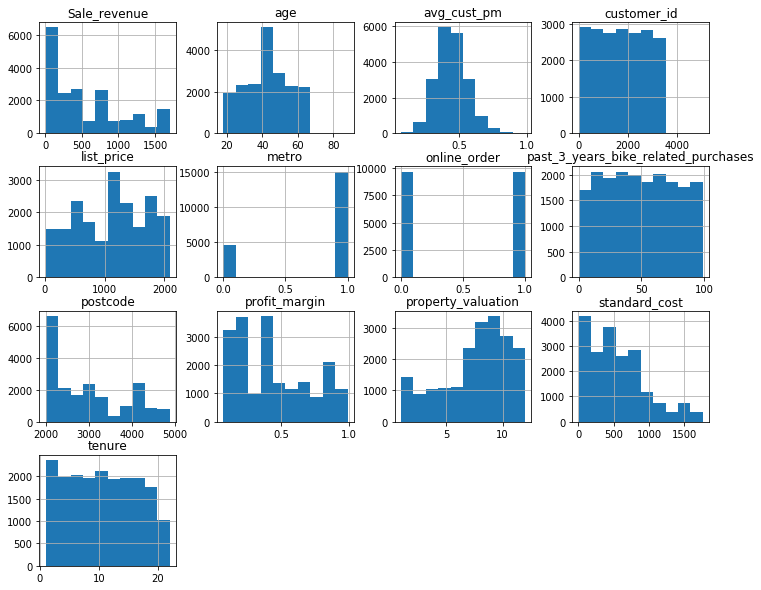

In [62]:
feat = df
feat.hist(figsize=(12,10));

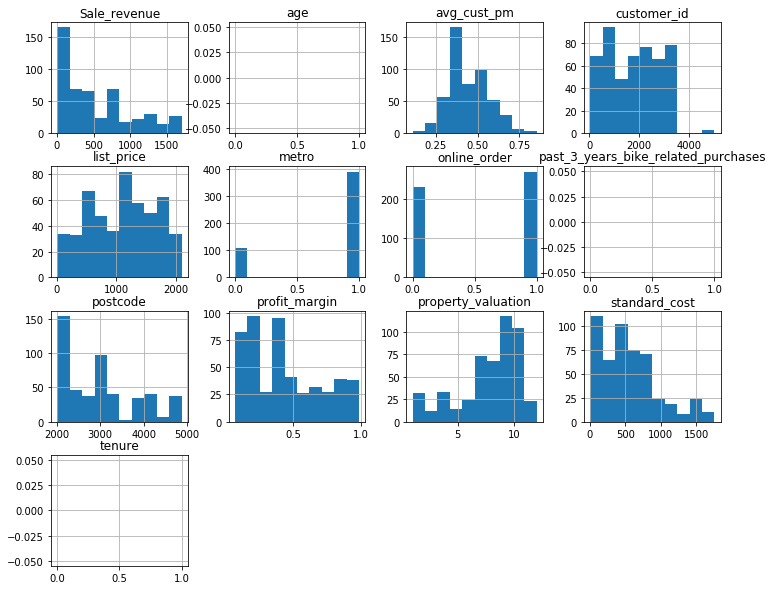

In [63]:
feat = df[df['gender'].isna()]
feat.hist(figsize=(12,10));

In [64]:
#remove rows with missing values
df = df[~df['gender'].isna()]

In [65]:
len(df)

19121

In [66]:
data = df.copy()

In [67]:
len(df)

19121

In [68]:
#Set dummy variables for categorical data and check for multicolinearity

# Of those, these are all of the variables that are categorical.
a = ['gender', 'wealth_segment', 'owns_car', 'state', 'property_valuation', 'agebin', 'metro']

#Generating a dictionary where the key is the column name and the value
#is a DF of dummy variable columns, dropping the first instance to avoid
#multicollinearity
b = {}
for i in a:
    b[i] = pd.get_dummies(df[i], prefix=i, drop_first=True)
    
len(df)

19121

In [69]:
#drop the columns I created dummys for
df = df.drop(a, axis=1)

len(df)

19121

In [70]:
#merging the dummy DFs to the original data frame and dropping the index column
#from each merge
for key in b:
    df = pd.merge(df, b[key],
                 how='outer',
                 left_on=df.index,
                 right_on = b[key].index)
    df = df.drop('key_0', axis=1)

print(len(df))
#view the columns to ensure I completed the dummy columns correctly
df.columns

20000


Index(['customer_id', 'online_order', 'brand', 'product_line', 'product_class',
       'product_size', 'list_price', 'standard_cost', 'season', 'Sale_revenue',
       'past_3_years_bike_related_purchases', 'job_industry_category',
       'tenure', 'age', 'postcode', 'profit_margin', 'avg_cust_pm', 'Target',
       'gender_Male', 'wealth_segment_High Net Worth',
       'wealth_segment_Mass Customer', 'owns_car_Yes', 'state_QLD',
       'state_VIC', 'property_valuation_2.0', 'property_valuation_3.0',
       'property_valuation_4.0', 'property_valuation_5.0',
       'property_valuation_6.0', 'property_valuation_7.0',
       'property_valuation_8.0', 'property_valuation_9.0',
       'property_valuation_10.0', 'property_valuation_11.0',
       'property_valuation_12.0', 'agebin_[25, 35)', 'agebin_[35, 45)',
       'agebin_[45, 55)', 'agebin_[55, 110)', 'metro_1.0'],
      dtype='object')

In [71]:
b['gender']

,gender_Male
0,1
1,1
2,0
3,1
4,1
5,1
6,0
7,1
8,1
9,0


In [53]:
len(df)

20000

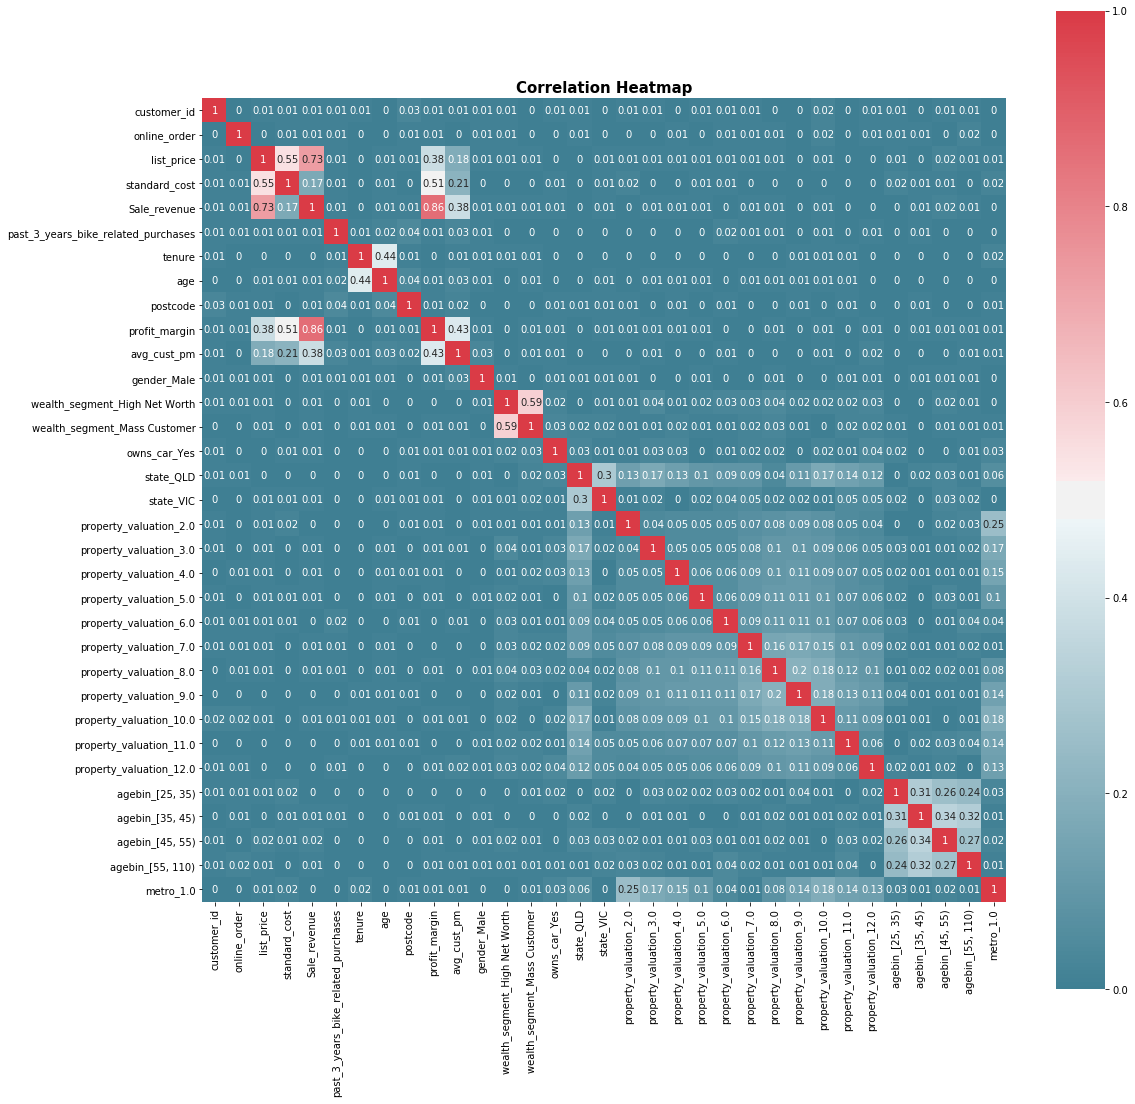

In [35]:
correlation = abs(round(df.corr(), 2))
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(correlation, annot = True, square=True, cmap =sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Correlation Heatmap',fontweight='bold',fontsize=15)
plt.show();

In [36]:
#Sale Revenue is the only variable the crosses the standard 0.75 threshold.
df = df.drop(['Sale_revenue'], axis=1)

In [37]:
len(df)

20000

In [20]:
df.loc[2]

customer_id                                   402
online_order                                    0
brand                                  OHM Cycles
product_line                             Standard
product_class                                 low
product_size                               medium
list_price                                1793.43
standard_cost                              248.82
season                                       Fall
past_3_years_bike_related_purchases            40
job_industry_category                         NaN
tenure                                         17
age                                            44
postcode                                     2756
profit_margin                             0.86126
avg_cust_pm                              0.535495
Target                                       High
gender_Male                                     0
wealth_segment_High Net Worth                   0
wealth_segment_Mass Customer                    1


In [21]:
len(df)

20000